/home/adriano/projeto_mestrado/modules/Vessel_Models_pickle/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 3-20X_savedata6.pickle
{'img_file': '/home/adriano/projeto_mestrado/modules/Imagens/vessel_data/images/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 3-20X.tiff', 'vessel_model': <Slice_mapper.slice_mapper.VesselModel object at 0x7f454ef1de80>, 'primeiro_ponto': array([1172,  690])}
/home/adriano/projeto_mestrado/modules/Vessel_Models_pickle/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@45-Image 1-20X_savedata1.pickle
{'img_file': '/home/adriano/projeto_mestrado/modules/Imagens/vessel_data/images/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@45-Image 1-20X.tiff', 'vessel_model': <Slice_mapper.slice_mapper.VesselModel object at 0x7f454efa6a60>, 'primeiro_ponto': array([1085,  394])}
/home/adriano/projeto_mestrado/modules/Vessel_Models_pickle/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Im

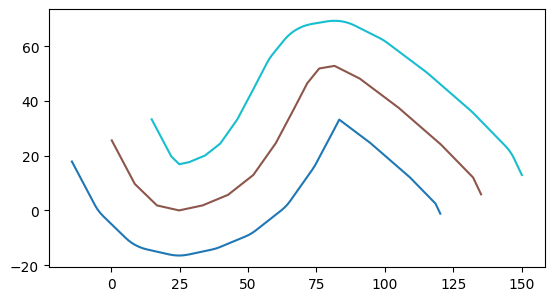

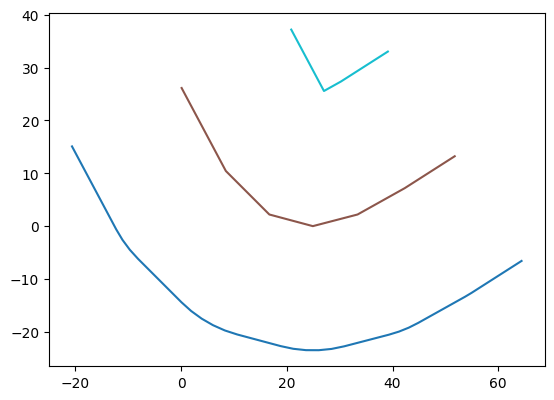

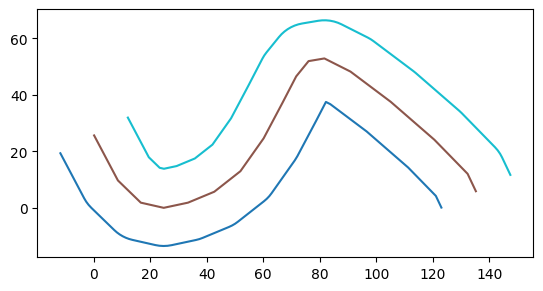

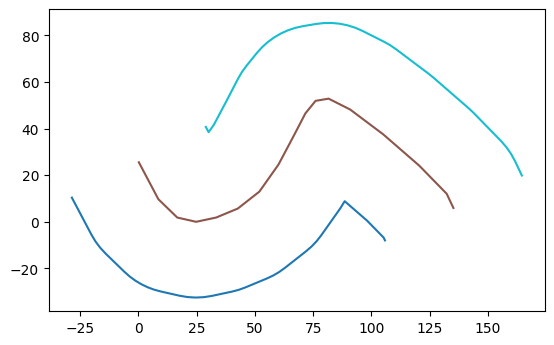

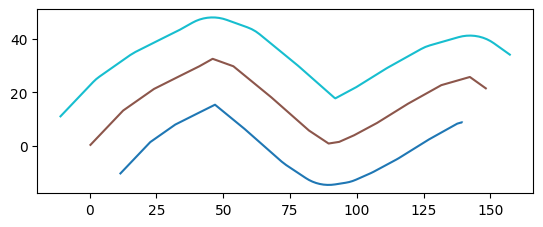

In [24]:
import pickle
import numpy as np
from PIL import Image
import sys
import geopandas as gpd

sys.path.insert(0, "/home/adriano/projeto_mestrado/modules")

from Funcoes_gerais import funcoes

import background_generation as backgen

root_dir = f"/home/adriano/projeto_mestrado/modules"

img_dir = f'{root_dir}/Imagens/vessel_data/images/'
lab_dir = f'{root_dir}/Imagens/vessel_data/labels_20x/'
pickle_dir = f'{root_dir}/Vessel_Models_pickle'

img_especifica = 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X'
array_pickles = funcoes.ler_diretorios(pickle_dir)
vetor_informacoes = []

for i in range(len(array_pickles)):

  path = (pickle_dir + f'/{array_pickles[i]}')
  #print(path)
  arquivo_pickle = pickle.load(open(path, 'rb'))
  #print(arquivo_pickle)
  vessel_map = arquivo_pickle['vessel_model'].vessel_map 
  mapa_original = vessel_map.mapped_values,
  imagem_binaria_original = vessel_map.mapped_mask_values
  #imagem_binaria_sem_artefatos_laterais = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original)
  #imagem_binaria_sem_artefatos = backgen.fill_holes(imagem_binaria_sem_artefatos_laterais)
  rows, cols = mapa_original[0].shape
  distancia = (rows/2)
 
  dict = {
      "path": path,
      "arquivo_pickle": arquivo_pickle,
      "vessel_map": vessel_map,
      "mapa_original": mapa_original,
      "imagem_binaria_original" : imagem_binaria_original,
      #imagem_binaria_sem_artefatos_laterais" : imagem_binaria_sem_artefatos_laterais,  
      #"imagem_binaria_sem_artefatos" : imagem_binaria_sem_artefatos,    
      "rows": rows,
      "cols": cols,
      "distancia": distancia
    }
  vetor_informacoes.append(dict)

array_tracados = f'{root_dir}/Artificial_Lines/array_arquivos.json'

medial_path = backgen.retorna_paths(array_tracados)

for i in range(len(medial_path)):    
    caminhos_transladados_interpolado = backgen.retorna_caminhos_transladados(medial_path[i], 2) # type: ignore
    distancia = vetor_informacoes[i]['distancia'] # type: ignore
   
    linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(caminhos_transladados_interpolado[0],distancia)

    gp4 = gpd.GeoSeries([linha_offset_esquerda, linha_central, linha_offset_direita])
    gp4.plot(cmap="tab10")





In [25]:
print(vetor_informacoes[0]['arquivo_pickle'])
print(vetor_informacoes[1]['arquivo_pickle'])
print(vetor_informacoes[2]['arquivo_pickle'])

print(array_pickles[0])
print(array_pickles[1])

{'img_file': '/home/adriano/projeto_mestrado/modules/Imagens/vessel_data/images/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 3-20X.tiff', 'vessel_model': <Slice_mapper.slice_mapper.VesselModel object at 0x7f454ef1de80>, 'primeiro_ponto': array([1172,  690])}
{'img_file': '/home/adriano/projeto_mestrado/modules/Imagens/vessel_data/images/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@45-Image 1-20X.tiff', 'vessel_model': <Slice_mapper.slice_mapper.VesselModel object at 0x7f454efa6a60>, 'primeiro_ponto': array([1085,  394])}
{'img_file': '/home/adriano/projeto_mestrado/modules/Imagens/vessel_data/images/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X.tiff', 'vessel_model': <Slice_mapper.slice_mapper.VesselModel object at 0x7f454ef1de20>, 'primeiro_ponto': array([413, 206])}
Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 3-20X_savedata6.pickle
Experiment #1 (adults set #1)_20x_batch1 - Superfical lay